__Statistical Learning in High Dimension__
<br>_Professor: M. Hebiri_
### TP2. Projection estimation
#### Exercise 1. Fourier
1.1 _Data simulation_

In [1]:
import numpy as np
n = 100
X = np.random.uniform(0, 1, 100)
def f(x):
    return ((x**2)*(2**(x-1))-(x-0.5)**3)*np.sin(10*x)
sigma = 0.2
Ksi = np.random.normal(0, 1, 100)
Y = f(X) + sigma*Ksi

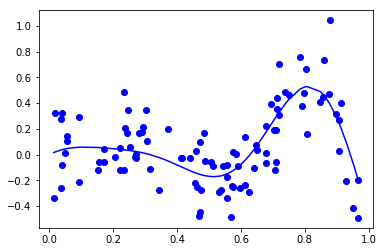

In [2]:
import matplotlib.pyplot as plt
ind_ord = X.argsort()
X = X[ind_ord]
Y = Y[ind_ord]
plt.plot(X, Y, 'bo')
plt.plot(X, f(X), '-b')
plt.show()

In [3]:
# Fourier basis
def phi (j, x):
    if j==1:
        return np.ones(len(x))
    elif (j%2==0):
        return np.sqrt(2)*np.cos(np.pi*j*x)
    else:
        return np.sqrt(2)*np.sin(np.pi*(j-1)*x)

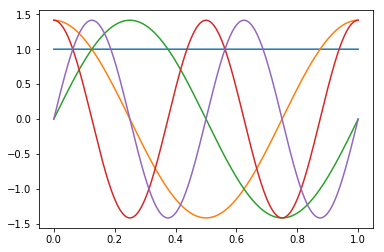

In [4]:
grid_x = np.linspace(0, 1, num = 10**4)
for j in np.arange(5)+1:
    plt.plot(grid_x, phi(j, grid_x), '-')
plt.show()

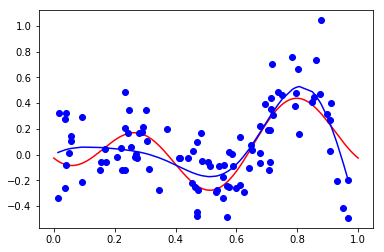

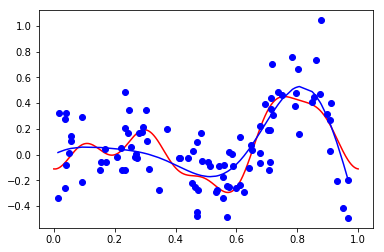

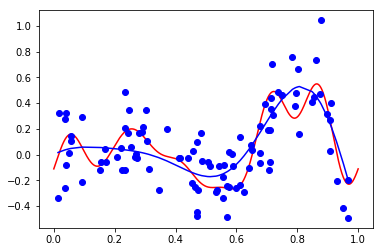

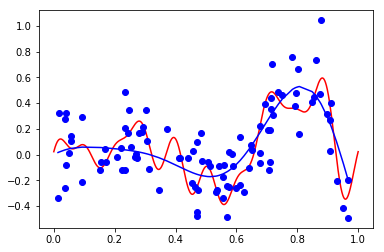

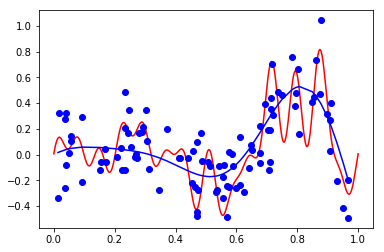

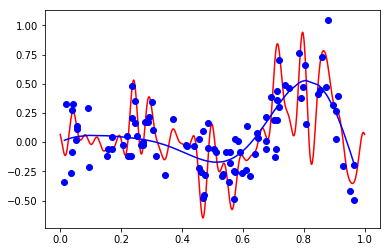

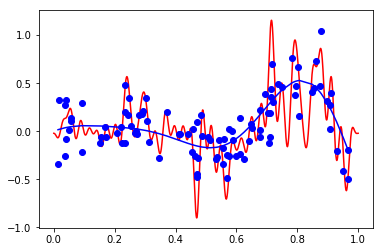

In [5]:
Ns = [5, 10, 15, 20, 30, 50, 70]
#Ns = [2,4,5,6,7,8,9]
# Projection estimator
# Calculate the Fourier coefficients:
def theta(X, Y, j):
    Theta = Y*phi(j, X)
    return np.mean(Theta)

def f_hat(N, x, X, Y):
    F = np.array([theta(X, Y, j)*phi(j, x) for j in np.arange(N)+1])
    return np.sum(F, axis=0)

for N in Ns:
    fN_hat = f_hat(N, grid_x, X, Y)
    plt.plot(grid_x, fN_hat,'-r')
    plt.plot(X, Y, 'bo')
    plt.plot(X, f(X), '-b')
    plt.show()

In [6]:
def err_Bv(N, v, V, X, Y):
    train_ind = [i for i, x in enumerate(X) if i % V != v]
    valid_ind = [i for i, x in enumerate(X) if i % V == v]
    f_v = f_hat(N, X[valid_ind], X[train_ind], Y[train_ind])
    return np.mean((f_v - Y[valid_ind])**2)

In [7]:
def err_cv(N, V, X, Y):
    err_l = np.array([err_Bv(N, v, V, X, Y) for v in np.arange(V)])
    return np.mean(err_l)

Optimal N is: 5


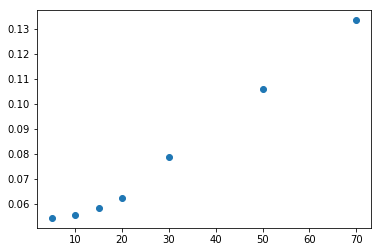

In [8]:
V = 10
errors = [err_cv(N, V, X, Y) for N in Ns]
N_opt = Ns[np.argmin(errors)]
print("Optimal N is: " + str(N_opt))
plt.plot(Ns, errors,'o')
plt.show()

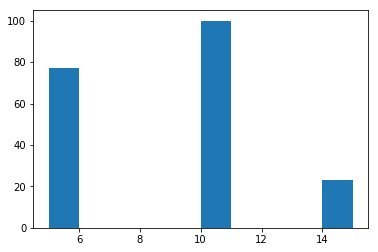

In [9]:
def Ns_opt (V):
    X = np.random.uniform(0, 1, 100)
    Ksi = np.random.normal(0, 1, 100)
    Y = f(X) + sigma*Ksi
    errors = [err_cv(N, V, X, Y) for N in Ns]
    N_opt = Ns[np.argmin(errors)]
    return N_opt
V = 50
Ns_opt = np.array([Ns_opt(V) for i in np.arange(200)])
plt.hist(Ns_opt)
plt.show()